In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

from IPython.display import clear_output
from time import sleep

In [20]:
class TaxiEnv:

    def __init__(self, method, alpha, temperature, env, gamma):
        self.env = env
        self.method = method
        self.positions = 25
        self.num_ps_location = 5
        self.num_ps_destination = 4
        self.num_states = self.positions * self.num_ps_location * self.num_ps_destination
        self.num_actions = 6
        self.alpha = alpha
        self.gamma = gamma
        self.temperature = temperature
        # initialize q table
        self.q = np.zeros(shape=(self.num_states, self.num_actions))
        # initialize policy
        self.pi = np.zeros_like(self.q)

    def interact(self):
        state = self.env.reset()
        delivered = False
        r_sum = 0
        steps = 0
        while not delivered:
            steps += 1
            action, probs = self._take_action(state)
            next_state, reward, delivered, info = self.env.step(action)

            if self.method == 'sarsa':
                next_action = self._take_action(next_state)[0]
                self.q[state][action] += self.alpha * \
                                         (reward + self.gamma * self.q[next_state][next_action] - self.q[state][action])
            elif self.method == 'q_learning':
                next_action = np.random.choice(np.where(self.q[next_state] == max(self.q[next_state]))[0])
                self.q[state][action] += self.alpha * \
                                         (reward + self.gamma * self.q[next_state][next_action] - self.q[state][action])
            elif self.method == 'expected_sarsa':
                self.q[state][action] += self.alpha * (reward + self.gamma * np.dot(probs, self.q[state][:])
                                                       - self.q[state][action])

            r_sum += reward
            state = next_state
        return r_sum

    def _take_action(self, state):
        self.pi[state] = np.exp(self.q[state] / self.temperature)
        prob = np.true_divide(self.pi[state], sum(self.pi[state]))
        a = np.random.choice(np.arange(6), p=prob)
        return a, prob

    def run_optimal_policy(self):
        state = self.env.reset()
        delivered = False
        r_sum = 0
        steps = 0
        while delivered == False:
            steps += 1
            action = np.random.choice(np.where(self.q[state] == max(self.q[state]))[0])
            next_state, reward, delivered, info = self.env.step(action)
            r_sum += reward
            state = next_state

            if delivered:
                print(end="")

        return r_sum

    def train(self, print_trace=False):
        runs = 10
        segments = 100
        episodes = 10

        train_rewards = []
        test_rewards = []

        reward_train_episodes = []
        reward_test_episode = []
        all_test_rewards = np.zeros(shape=(runs, segments))

        for run in range(runs):
            self.q = np.zeros(shape=(self.num_states, self.num_actions))
            for segment in range(segments):
                train_rewards = []
                for episode in range(episodes + 1):
                    if episode < episodes:
                        reward_sum = self.interact()
                        train_rewards.append(reward_sum)
                    else:
                        test_reward = self.run_optimal_policy()
                        test_rewards.append(test_reward)
                    if print_trace:
                        if episode == episodes:
                            all_test_rewards[run][segment] = test_rewards[-1]
                            if segment % 10 == 0 or segment == 99:
                                print('{} | alpha {}, tau {:3.2f} | Run {:2d}, Segment {:2d}'.
                                      format(self.method, self.alpha, self.temperature, run, segment), end=" ")
                                print('| train reward {:8.2f}, test_reward {}'.
                                      format(np.mean(train_rewards[episode - 10:episode]), test_rewards[-1]))
                    if episode == episodes and segment == segments - 1:  # last segment, last episode
                        reward_train_episodes.append(np.mean(train_rewards))
                        reward_test_episode.append(test_rewards[-1])

        train_per_run = np.mean(reward_train_episodes)    # for the first bullet in the question
        test_per_run = np.mean(reward_test_episode)       # for the second bullet in the question
        avg_test_reward_per_run = np.mean(all_test_rewards, axis=0)  # for the third bullet in the question
        std_test_reward_per_run = np.std(all_test_rewards, axis=0)   # for the third bullet in the question

        return train_per_run, test_per_run, avg_test_reward_per_run, std_test_reward_per_run

In [3]:
env = gym.make('Taxi-v2')

learning_rates = [0.3, 0.5, 0.8]
temperatures = [0.5, 1, 1.5]

In [4]:
def plot_graph(x_value, y_values, legend_names, x_axis_title, y_axis_title, filename_to_save):
    fig = plt.figure(1)
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(y_values)):
        ax.plot(x_value,
                y_values[i],
                label=legend_names[i])
    ax.set_xlabel(x_axis_title)
    ax.set_ylabel(y_axis_title)

    plt.legend(loc='upper left')
#     if saveFigures:
#         plt.savefig(filename_to_save)
#     if plot_graph_:
    plt.show()
    plt.clf()

In [5]:
def plot_error(x, y, e, alpha, tau):
    fig, ax = plt.subplots()
    ax.errorbar(x, y, e,  linestyle='solid', marker='o')
    ax.set_title('Learning curve for alpha {} - tau {}'.format(alpha, tau))
    ax.set_xlabel('Segments')
    ax.set_ylabel('Mean and Std test rewards')
    plt.show()

sarsa | alpha 0.3, tau 0.50 | Run  0, Segment  0 | train reward  -449.30, test_reward -848
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 10 | train reward  -198.20, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 20 | train reward  -133.80, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 30 | train reward   -55.40, test_reward 11
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 40 | train reward   -20.20, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 50 | train reward    -8.20, test_reward 9
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 60 | train reward     0.80, test_reward 3
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 70 | train reward     6.80, test_reward 9
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 80 | train reward     5.50, test_reward 3
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 90 | train reward     6.60, test_reward 14
sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 99 | train reward     6.90, test_reward 9
sarsa | alpha 0.3,

sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 40 | train reward    -9.10, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 50 | train reward   -10.30, test_reward 12
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 60 | train reward     8.20, test_reward 12
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 70 | train reward     1.50, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 80 | train reward     6.20, test_reward 7
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 90 | train reward     0.70, test_reward 9
sarsa | alpha 0.3, tau 0.50 | Run  8, Segment 99 | train reward     4.30, test_reward 8
sarsa | alpha 0.3, tau 0.50 | Run  9, Segment  0 | train reward  -544.70, test_reward -1280
sarsa | alpha 0.3, tau 0.50 | Run  9, Segment 10 | train reward  -209.90, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  9, Segment 20 | train reward   -95.10, test_reward -200
sarsa | alpha 0.3, tau 0.50 | Run  9, Segment 30 | train reward   -45.60, test_reward 13
sarsa | alpha

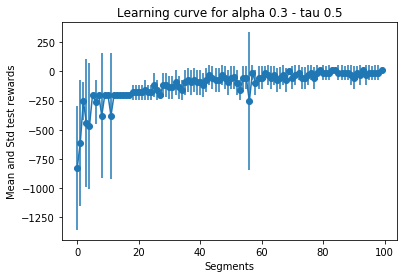

sarsa | alpha 0.5, tau 0.50 | Run  0, Segment  0 | train reward  -458.10, test_reward -686
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 10 | train reward  -167.20, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 20 | train reward   -57.90, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 30 | train reward   -16.20, test_reward 12
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 40 | train reward     5.10, test_reward 7
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 50 | train reward     3.30, test_reward 9
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 60 | train reward     8.20, test_reward 7
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 70 | train reward     6.70, test_reward 7
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 80 | train reward     8.40, test_reward 11
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 90 | train reward     5.60, test_reward 8
sarsa | alpha 0.5, tau 0.50 | Run  0, Segment 99 | train reward     8.40, test_reward 10
sarsa | alpha 0.5, t

sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 40 | train reward     1.80, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 50 | train reward     6.50, test_reward 6
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 60 | train reward     6.50, test_reward 5
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 70 | train reward     7.00, test_reward 11
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 80 | train reward     6.50, test_reward 12
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 90 | train reward     8.20, test_reward 7
sarsa | alpha 0.5, tau 0.50 | Run  8, Segment 99 | train reward     7.40, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  9, Segment  0 | train reward  -451.40, test_reward -677
sarsa | alpha 0.5, tau 0.50 | Run  9, Segment 10 | train reward  -118.60, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  9, Segment 20 | train reward   -29.60, test_reward -200
sarsa | alpha 0.5, tau 0.50 | Run  9, Segment 30 | train reward    -3.50, test_reward -200
sarsa | alph

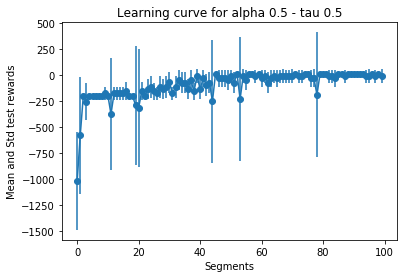

sarsa | alpha 0.8, tau 0.50 | Run  0, Segment  0 | train reward  -489.90, test_reward -200
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 10 | train reward   -68.70, test_reward -200
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 20 | train reward   -43.00, test_reward 7
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 30 | train reward    -9.80, test_reward -200
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 40 | train reward     7.20, test_reward 6
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 50 | train reward     6.30, test_reward -200
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 60 | train reward     6.10, test_reward 3
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 70 | train reward     5.40, test_reward 10
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 80 | train reward     8.60, test_reward 5
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 90 | train reward     8.30, test_reward 8
sarsa | alpha 0.8, tau 0.50 | Run  0, Segment 99 | train reward     8.20, test_reward 6
sarsa | alpha 0.8, 

sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 40 | train reward    -2.60, test_reward 10
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 50 | train reward     8.80, test_reward 6
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 60 | train reward     8.80, test_reward 10
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 70 | train reward     7.20, test_reward 6
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 80 | train reward     8.70, test_reward 8
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 90 | train reward     6.90, test_reward 8
sarsa | alpha 0.8, tau 0.50 | Run  8, Segment 99 | train reward     6.60, test_reward -200
sarsa | alpha 0.8, tau 0.50 | Run  9, Segment  0 | train reward  -498.00, test_reward -866
sarsa | alpha 0.8, tau 0.50 | Run  9, Segment 10 | train reward   -43.10, test_reward -200
sarsa | alpha 0.8, tau 0.50 | Run  9, Segment 20 | train reward    -9.60, test_reward -200
sarsa | alpha 0.8, tau 0.50 | Run  9, Segment 30 | train reward    -8.20, test_reward 11
sarsa | alpha 0.8

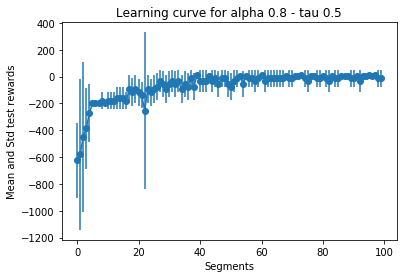

sarsa | alpha 0.3, tau 1.00 | Run  0, Segment  0 | train reward  -443.10, test_reward -281
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 10 | train reward  -215.80, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 20 | train reward  -176.30, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 30 | train reward   -67.60, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 40 | train reward   -63.90, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 50 | train reward   -58.90, test_reward 9
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 60 | train reward   -18.40, test_reward 7
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 70 | train reward     0.80, test_reward 6
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 80 | train reward     4.30, test_reward 7
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 90 | train reward     5.70, test_reward 9
sarsa | alpha 0.3, tau 1.00 | Run  0, Segment 99 | train reward     6.50, test_reward 9
sarsa | alpha 0.3

sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 40 | train reward  -128.40, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 50 | train reward    -2.20, test_reward 12
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 60 | train reward     0.90, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 70 | train reward     1.90, test_reward 8
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 80 | train reward    -4.30, test_reward 10
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 90 | train reward     8.70, test_reward 9
sarsa | alpha 0.3, tau 1.00 | Run  8, Segment 99 | train reward     4.80, test_reward 10
sarsa | alpha 0.3, tau 1.00 | Run  9, Segment  0 | train reward  -524.90, test_reward -722
sarsa | alpha 0.3, tau 1.00 | Run  9, Segment 10 | train reward  -232.10, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  9, Segment 20 | train reward  -163.30, test_reward -200
sarsa | alpha 0.3, tau 1.00 | Run  9, Segment 30 | train reward  -119.60, test_reward -200
sarsa | alp

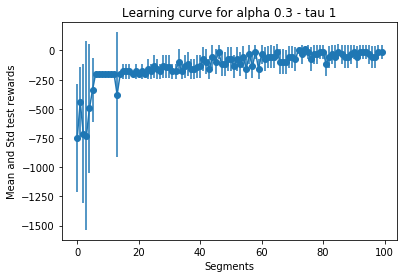

sarsa | alpha 0.5, tau 1.00 | Run  0, Segment  0 | train reward  -405.10, test_reward -749
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 10 | train reward  -153.30, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 20 | train reward   -84.70, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 30 | train reward   -60.70, test_reward 7
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 40 | train reward   -23.90, test_reward 12
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 50 | train reward     4.40, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 60 | train reward     3.80, test_reward 10
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 70 | train reward     2.40, test_reward 6
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 80 | train reward     8.50, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 90 | train reward     8.00, test_reward 7
sarsa | alpha 0.5, tau 1.00 | Run  0, Segment 99 | train reward     8.50, test_reward 7
sarsa | alpha 0

sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 40 | train reward     5.80, test_reward 8
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 50 | train reward     4.70, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 60 | train reward     7.20, test_reward 7
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 70 | train reward     5.90, test_reward 15
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 80 | train reward     6.30, test_reward 12
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 90 | train reward     8.40, test_reward 6
sarsa | alpha 0.5, tau 1.00 | Run  8, Segment 99 | train reward     9.50, test_reward 8
sarsa | alpha 0.5, tau 1.00 | Run  9, Segment  0 | train reward  -444.00, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  9, Segment 10 | train reward  -142.20, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  9, Segment 20 | train reward   -95.70, test_reward -200
sarsa | alpha 0.5, tau 1.00 | Run  9, Segment 30 | train reward   -22.50, test_reward -200
sarsa | alpha 0

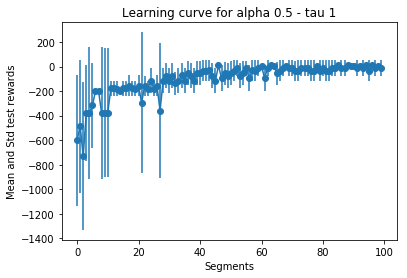

sarsa | alpha 0.8, tau 1.00 | Run  0, Segment  0 | train reward  -519.10, test_reward -911
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 10 | train reward  -189.20, test_reward -200
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 20 | train reward  -112.70, test_reward 5
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 30 | train reward     7.20, test_reward 9
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 40 | train reward     2.70, test_reward -200
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 50 | train reward     4.00, test_reward 11
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 60 | train reward    -5.10, test_reward 8
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 70 | train reward     6.70, test_reward 3
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 80 | train reward     6.40, test_reward 13
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 90 | train reward     6.30, test_reward 7
sarsa | alpha 0.8, tau 1.00 | Run  0, Segment 99 | train reward     5.80, test_reward 5
sarsa | alpha 0.8, ta

sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 40 | train reward     4.10, test_reward 8
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 50 | train reward     8.30, test_reward 5
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 60 | train reward     5.30, test_reward 10
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 70 | train reward     1.70, test_reward 3
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 80 | train reward     7.50, test_reward 10
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 90 | train reward     7.70, test_reward 11
sarsa | alpha 0.8, tau 1.00 | Run  8, Segment 99 | train reward     3.00, test_reward 7
sarsa | alpha 0.8, tau 1.00 | Run  9, Segment  0 | train reward  -496.10, test_reward -668
sarsa | alpha 0.8, tau 1.00 | Run  9, Segment 10 | train reward  -188.90, test_reward -200
sarsa | alpha 0.8, tau 1.00 | Run  9, Segment 20 | train reward   -47.80, test_reward -200
sarsa | alpha 0.8, tau 1.00 | Run  9, Segment 30 | train reward     3.40, test_reward 8
sarsa | alpha 0.8, t

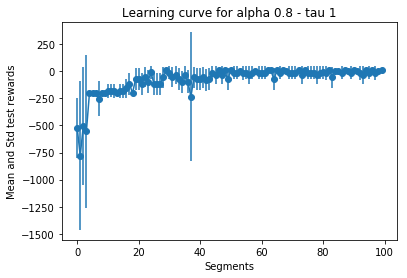

sarsa | alpha 0.3, tau 1.50 | Run  0, Segment  0 | train reward  -514.00, test_reward -722
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 10 | train reward  -278.80, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 20 | train reward  -166.80, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 30 | train reward  -111.80, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 40 | train reward   -78.40, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 50 | train reward   -91.00, test_reward 12
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 60 | train reward   -70.70, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 70 | train reward   -21.30, test_reward 6
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 80 | train reward     6.30, test_reward 8
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 90 | train reward    -6.40, test_reward 12
sarsa | alpha 0.3, tau 1.50 | Run  0, Segment 99 | train reward     8.60, test_reward 10
sarsa | alp

sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 40 | train reward   -69.90, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 50 | train reward   -23.80, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 60 | train reward   -20.60, test_reward 10
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 70 | train reward     7.20, test_reward 10
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 80 | train reward    10.20, test_reward 10
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 90 | train reward   -14.10, test_reward 11
sarsa | alpha 0.3, tau 1.50 | Run  8, Segment 99 | train reward    -2.60, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  9, Segment  0 | train reward  -502.40, test_reward -866
sarsa | alpha 0.3, tau 1.50 | Run  9, Segment 10 | train reward  -187.00, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  9, Segment 20 | train reward   -96.90, test_reward -200
sarsa | alpha 0.3, tau 1.50 | Run  9, Segment 30 | train reward   -66.80, test_reward -200
sarsa |

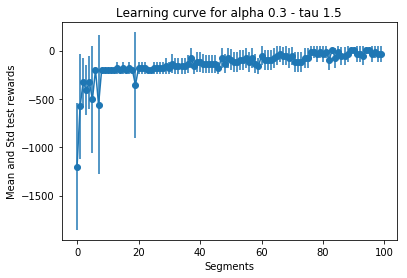

sarsa | alpha 0.5, tau 1.50 | Run  0, Segment  0 | train reward  -476.70, test_reward -1973
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 10 | train reward  -135.00, test_reward -200
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 20 | train reward  -120.80, test_reward -200
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 30 | train reward   -75.50, test_reward 13
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 40 | train reward   -32.00, test_reward 10
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 50 | train reward     2.90, test_reward 5
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 60 | train reward   -29.50, test_reward 7
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 70 | train reward    -1.00, test_reward -200
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 80 | train reward     5.50, test_reward 12
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 90 | train reward     2.60, test_reward 9
sarsa | alpha 0.5, tau 1.50 | Run  0, Segment 99 | train reward     5.60, test_reward 8
sarsa | alpha 0.

sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 40 | train reward   -23.60, test_reward 11
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 50 | train reward   -12.70, test_reward -200
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 60 | train reward     2.90, test_reward 9
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 70 | train reward     7.40, test_reward 6
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 80 | train reward     7.30, test_reward 9
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 90 | train reward     7.50, test_reward 12
sarsa | alpha 0.5, tau 1.50 | Run  8, Segment 99 | train reward     5.70, test_reward 6
sarsa | alpha 0.5, tau 1.50 | Run  9, Segment  0 | train reward  -496.50, test_reward -839
sarsa | alpha 0.5, tau 1.50 | Run  9, Segment 10 | train reward  -193.70, test_reward -200
sarsa | alpha 0.5, tau 1.50 | Run  9, Segment 20 | train reward  -192.10, test_reward -200
sarsa | alpha 0.5, tau 1.50 | Run  9, Segment 30 | train reward   -58.40, test_reward 6
sarsa | alpha 0.5,

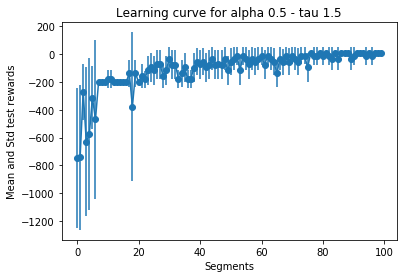

sarsa | alpha 0.8, tau 1.50 | Run  0, Segment  0 | train reward  -472.50, test_reward -2000
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 10 | train reward  -189.20, test_reward -200
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 20 | train reward  -125.60, test_reward -200
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 30 | train reward   -14.40, test_reward 12
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 40 | train reward   -14.70, test_reward 9
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 50 | train reward     5.40, test_reward 6
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 60 | train reward     5.00, test_reward 8
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 70 | train reward    -2.40, test_reward 14
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 80 | train reward     6.50, test_reward 12
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 90 | train reward     1.30, test_reward 10
sarsa | alpha 0.8, tau 1.50 | Run  0, Segment 99 | train reward   -10.50, test_reward 9
sarsa | alpha 0.8,

sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 40 | train reward    -7.30, test_reward -200
sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 50 | train reward     3.00, test_reward 7
sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 60 | train reward     0.50, test_reward 13
sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 70 | train reward    -0.40, test_reward 10
sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 80 | train reward     5.80, test_reward 13
sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 90 | train reward     5.90, test_reward 4
sarsa | alpha 0.8, tau 1.50 | Run  8, Segment 99 | train reward    -0.70, test_reward 10
sarsa | alpha 0.8, tau 1.50 | Run  9, Segment  0 | train reward  -417.60, test_reward -1001
sarsa | alpha 0.8, tau 1.50 | Run  9, Segment 10 | train reward  -162.10, test_reward -200
sarsa | alpha 0.8, tau 1.50 | Run  9, Segment 20 | train reward   -36.30, test_reward 12
sarsa | alpha 0.8, tau 1.50 | Run  9, Segment 30 | train reward     3.70, test_reward -200
sarsa | alpha 

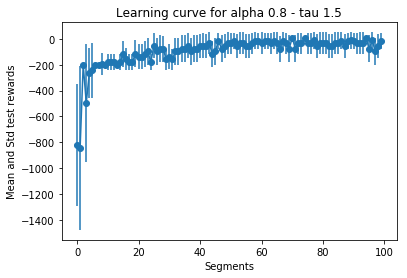

In [8]:
agents = ['sarsa']
for agent in agents:
    agent_train_rewards = np.zeros(shape=(len(temperatures), len(learning_rates)))
    agent_test_rewards = np.zeros_like(agent_train_rewards)
    for temp in temperatures:
        for learning_rate in learning_rates:
            agent_object = TaxiEnv(agent, learning_rate, temp, env, gamma=0.9)
            train_rewards, test_rewards, avg_test, std_test = agent_object.train(print_trace=True)
            agent_train_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = train_rewards
            agent_test_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = test_rewards
            
            plt.rcParams['figure.figsize'] = [15, 7]
            plot_error(np.arange(100), avg_test, std_test, learning_rate, temp)

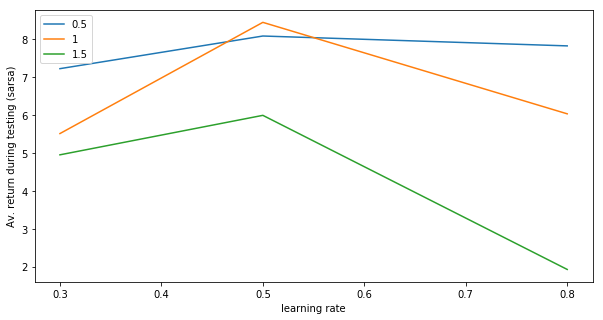

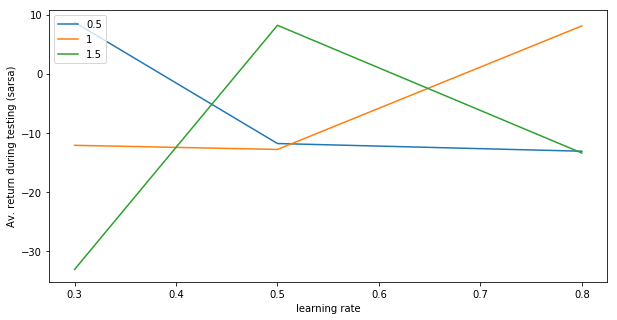

<Figure size 720x360 with 0 Axes>

In [12]:
# plots for 'sarsa' training and test
plt.rcParams['figure.figsize'] = [10, 5]
plot_graph(learning_rates, agent_train_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')
plot_graph(learning_rates, agent_test_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')

q_learning | alpha 0.3, tau 0.50 | Run  0, Segment  0 | train reward  -455.50, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 10 | train reward  -131.40, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 20 | train reward   -86.40, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 30 | train reward   -36.60, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 40 | train reward   -24.50, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 50 | train reward   -11.40, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 60 | train reward    -2.10, test_reward 4
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 70 | train reward     3.60, test_reward 11
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 80 | train reward     2.20, test_reward 8
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 90 | train reward     2.20, test_reward 9
q_learning | alpha 0.3, tau 0.50 | Run  0, Segment 

q_learning | alpha 0.3, tau 0.50 | Run  8, Segment  0 | train reward  -522.20, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 10 | train reward  -192.80, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 20 | train reward   -96.30, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 30 | train reward   -16.40, test_reward 12
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 40 | train reward   -24.10, test_reward 8
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 50 | train reward     5.20, test_reward 9
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 60 | train reward     7.20, test_reward -200
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 70 | train reward     8.80, test_reward 9
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 80 | train reward     8.80, test_reward 11
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 90 | train reward     3.90, test_reward 11
q_learning | alpha 0.3, tau 0.50 | Run  8, Segment 99 |

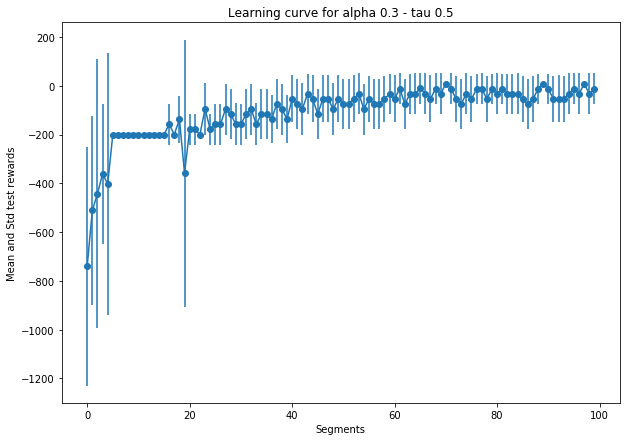

q_learning | alpha 0.5, tau 0.50 | Run  0, Segment  0 | train reward  -498.80, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 10 | train reward  -168.00, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 20 | train reward   -83.80, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 30 | train reward    -6.30, test_reward 7
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 40 | train reward    -0.40, test_reward 9
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 50 | train reward    -1.40, test_reward 8
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 60 | train reward     6.20, test_reward 9
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 70 | train reward     5.90, test_reward 9
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 80 | train reward     6.90, test_reward 10
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 90 | train reward     8.10, test_reward 9
q_learning | alpha 0.5, tau 0.50 | Run  0, Segment 99 | trai

q_learning | alpha 0.5, tau 0.50 | Run  7, Segment 99 | train reward     7.40, test_reward 4
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment  0 | train reward  -507.50, test_reward -758
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 10 | train reward  -109.20, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 20 | train reward   -65.20, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 30 | train reward     5.10, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 40 | train reward    -6.10, test_reward 13
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 50 | train reward     6.10, test_reward 3
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 60 | train reward     6.90, test_reward -200
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 70 | train reward     6.40, test_reward 7
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 80 | train reward     8.20, test_reward 7
q_learning | alpha 0.5, tau 0.50 | Run  8, Segment 90 

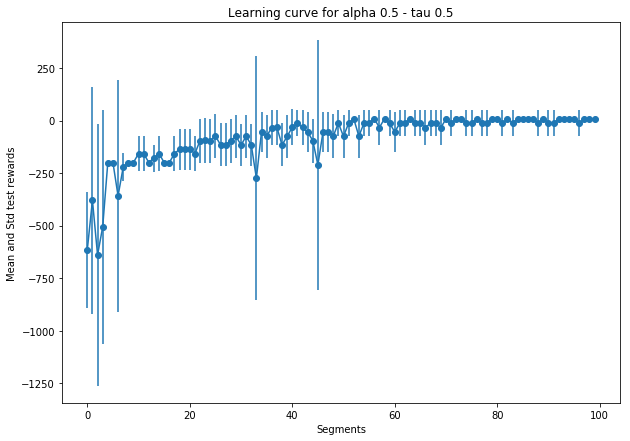

q_learning | alpha 0.8, tau 0.50 | Run  0, Segment  0 | train reward  -460.90, test_reward -884
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 10 | train reward   -81.00, test_reward -200
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 20 | train reward     0.90, test_reward 9
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 30 | train reward     3.60, test_reward 7
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 40 | train reward     6.90, test_reward 6
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 50 | train reward     8.90, test_reward -200
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 60 | train reward     7.60, test_reward 1
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 70 | train reward     7.10, test_reward 7
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 80 | train reward     7.00, test_reward 10
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 90 | train reward     8.50, test_reward 5
q_learning | alpha 0.8, tau 0.50 | Run  0, Segment 99 | trai

q_learning | alpha 0.8, tau 0.50 | Run  8, Segment  0 | train reward  -528.50, test_reward -812
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 10 | train reward   -66.40, test_reward -200
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 20 | train reward   -16.60, test_reward 11
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 30 | train reward    -7.60, test_reward 9
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 40 | train reward     9.20, test_reward 9
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 50 | train reward     6.50, test_reward 12
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 60 | train reward     7.20, test_reward 8
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 70 | train reward     9.00, test_reward 10
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 80 | train reward     7.50, test_reward 9
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 90 | train reward     8.50, test_reward 11
q_learning | alpha 0.8, tau 0.50 | Run  8, Segment 99 | trai

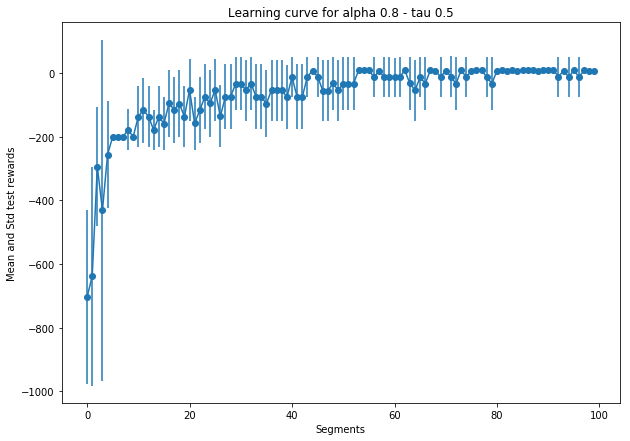

q_learning | alpha 0.3, tau 1.00 | Run  0, Segment  0 | train reward  -515.90, test_reward -722
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 10 | train reward  -204.90, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 20 | train reward  -153.80, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 30 | train reward   -75.40, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 40 | train reward   -24.80, test_reward 11
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 50 | train reward    -1.90, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 60 | train reward    -5.70, test_reward 9
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 70 | train reward     6.10, test_reward 8
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 80 | train reward     1.60, test_reward 13
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment 90 | train reward     3.20, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  0, Segment

q_learning | alpha 0.3, tau 1.00 | Run  7, Segment 99 | train reward     8.30, test_reward 9
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment  0 | train reward  -537.50, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 10 | train reward  -218.80, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 20 | train reward  -119.40, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 30 | train reward   -82.80, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 40 | train reward   -61.30, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 50 | train reward   -12.40, test_reward 9
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 60 | train reward     1.70, test_reward -200
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 70 | train reward    -5.70, test_reward 10
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 80 | train reward     6.40, test_reward 5
q_learning | alpha 0.3, tau 1.00 | Run  8, Segment 

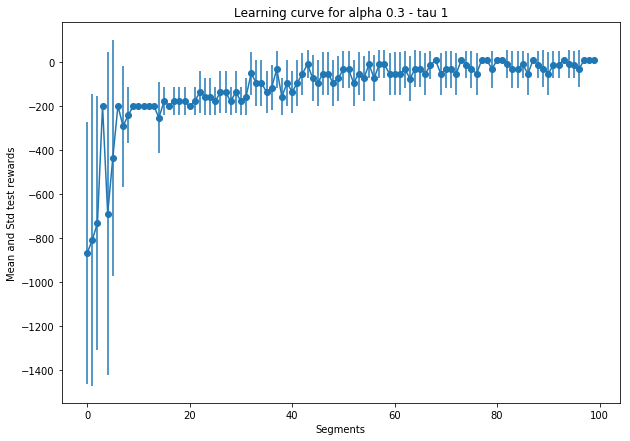

q_learning | alpha 0.5, tau 1.00 | Run  0, Segment  0 | train reward  -457.40, test_reward -758
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 10 | train reward  -143.40, test_reward -200
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 20 | train reward   -56.60, test_reward -200
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 30 | train reward    -7.20, test_reward 11
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 40 | train reward    -5.00, test_reward 6
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 50 | train reward     5.40, test_reward 10
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 60 | train reward     4.00, test_reward 8
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 70 | train reward     6.00, test_reward 7
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 80 | train reward     5.40, test_reward 8
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 90 | train reward     7.00, test_reward 12
q_learning | alpha 0.5, tau 1.00 | Run  0, Segment 99 | tr

q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 10 | train reward  -178.80, test_reward -200
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 20 | train reward   -27.10, test_reward -200
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 30 | train reward    -6.50, test_reward 7
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 40 | train reward   -10.40, test_reward 6
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 50 | train reward     5.60, test_reward 8
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 60 | train reward     8.00, test_reward 12
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 70 | train reward     5.90, test_reward 5
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 80 | train reward     8.80, test_reward 7
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 90 | train reward     9.70, test_reward 11
q_learning | alpha 0.5, tau 1.00 | Run  8, Segment 99 | train reward     6.30, test_reward 10
q_learning | alpha 0.5, tau 1.00 | Run  9, Segment  0 | train

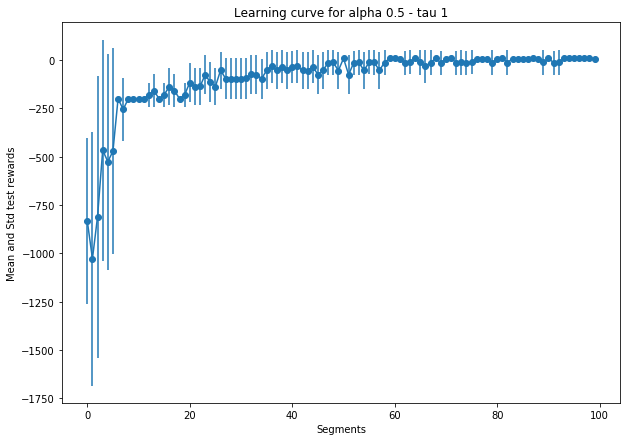

q_learning | alpha 0.8, tau 1.00 | Run  0, Segment  0 | train reward  -398.40, test_reward -785
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 10 | train reward  -139.90, test_reward -200
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 20 | train reward   -70.70, test_reward -200
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 30 | train reward    -7.50, test_reward 10
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 40 | train reward    -0.50, test_reward 6
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 50 | train reward     2.50, test_reward -200
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 60 | train reward     8.00, test_reward 5
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 70 | train reward     7.30, test_reward 9
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 80 | train reward     7.20, test_reward 10
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 90 | train reward     8.30, test_reward 5
q_learning | alpha 0.8, tau 1.00 | Run  0, Segment 99 | 

q_learning | alpha 0.8, tau 1.00 | Run  7, Segment 99 | train reward     7.20, test_reward 7
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment  0 | train reward  -421.30, test_reward -722
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 10 | train reward   -96.90, test_reward 14
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 20 | train reward   -30.50, test_reward 12
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 30 | train reward    -4.50, test_reward 11
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 40 | train reward    -3.70, test_reward 7
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 50 | train reward     5.70, test_reward 6
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 60 | train reward     8.00, test_reward 6
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 70 | train reward     7.40, test_reward 3
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 80 | train reward     7.40, test_reward 6
q_learning | alpha 0.8, tau 1.00 | Run  8, Segment 90 | train re

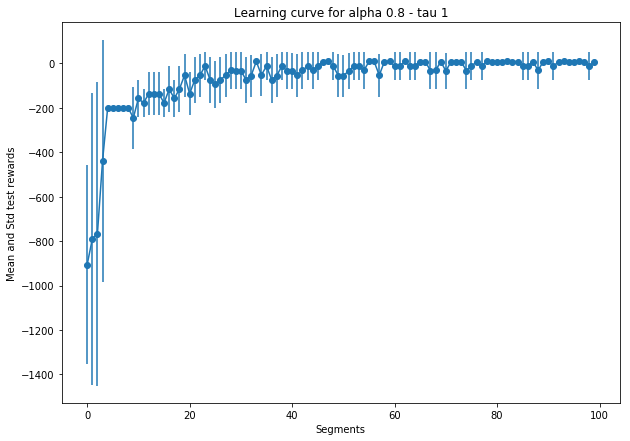

q_learning | alpha 0.3, tau 1.50 | Run  0, Segment  0 | train reward  -496.00, test_reward -1982
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 10 | train reward  -165.70, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 20 | train reward  -175.70, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 30 | train reward   -64.40, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 40 | train reward   -76.10, test_reward 9
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 50 | train reward   -19.30, test_reward 10
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 60 | train reward   -29.30, test_reward 8
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 70 | train reward   -10.60, test_reward 9
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 80 | train reward     4.30, test_reward 9
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 90 | train reward     4.80, test_reward 9
q_learning | alpha 0.3, tau 1.50 | Run  0, Segment 99 | 

q_learning | alpha 0.3, tau 1.50 | Run  7, Segment 99 | train reward     1.10, test_reward 6
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment  0 | train reward  -486.50, test_reward -2000
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 10 | train reward  -238.30, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 20 | train reward  -170.90, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 30 | train reward  -110.30, test_reward 9
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 40 | train reward   -38.70, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 50 | train reward   -54.10, test_reward -200
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 60 | train reward    -9.60, test_reward 7
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 70 | train reward    -6.70, test_reward 10
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 80 | train reward    -5.80, test_reward 8
q_learning | alpha 0.3, tau 1.50 | Run  8, Segment 90

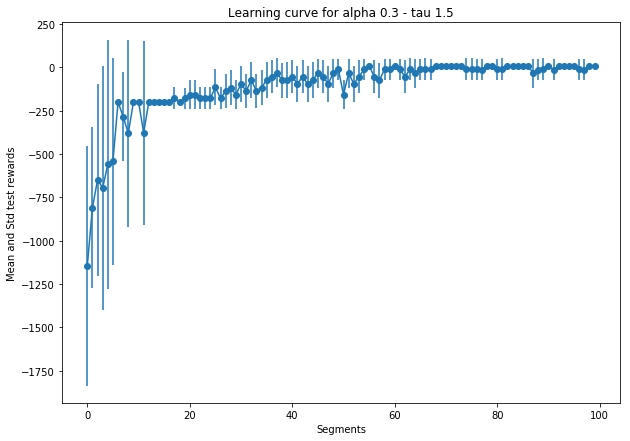

q_learning | alpha 0.5, tau 1.50 | Run  0, Segment  0 | train reward  -404.10, test_reward -920
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 10 | train reward  -247.70, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 20 | train reward   -63.40, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 30 | train reward   -59.00, test_reward 6
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 40 | train reward   -14.00, test_reward 12
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 50 | train reward    -0.70, test_reward 13
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 60 | train reward     0.50, test_reward 14
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 70 | train reward     0.70, test_reward 9
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 80 | train reward     3.30, test_reward 5
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 90 | train reward     1.70, test_reward 6
q_learning | alpha 0.5, tau 1.50 | Run  0, Segment 99 | tr

q_learning | alpha 0.5, tau 1.50 | Run  7, Segment 99 | train reward     0.50, test_reward 11
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment  0 | train reward  -472.80, test_reward -812
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 10 | train reward  -236.50, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 20 | train reward   -98.80, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 30 | train reward   -46.20, test_reward -200
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 40 | train reward     0.90, test_reward 7
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 50 | train reward     7.10, test_reward 8
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 60 | train reward     5.90, test_reward 14
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 70 | train reward     6.20, test_reward 9
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 80 | train reward     3.30, test_reward 6
q_learning | alpha 0.5, tau 1.50 | Run  8, Segment 90 | 

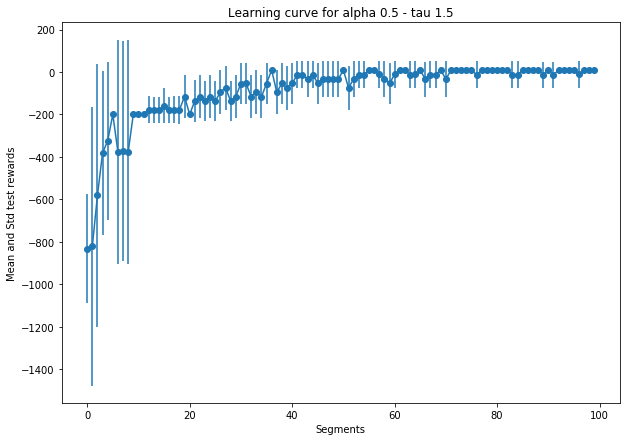

q_learning | alpha 0.8, tau 1.50 | Run  0, Segment  0 | train reward  -446.50, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 10 | train reward  -167.90, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 20 | train reward   -29.50, test_reward 11
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 30 | train reward    -0.30, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 40 | train reward     6.40, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 50 | train reward     4.00, test_reward 6
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 60 | train reward     2.50, test_reward 8
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 70 | train reward     3.30, test_reward 12
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 80 | train reward     7.40, test_reward 9
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 90 | train reward     5.40, test_reward 9
q_learning | alpha 0.8, tau 1.50 | Run  0, Segment 99 | 

q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 10 | train reward  -131.30, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 20 | train reward   -88.00, test_reward -200
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 30 | train reward    -7.70, test_reward 5
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 40 | train reward     5.30, test_reward 8
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 50 | train reward     2.10, test_reward 8
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 60 | train reward     4.00, test_reward 5
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 70 | train reward     2.50, test_reward 8
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 80 | train reward     2.00, test_reward 5
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 90 | train reward     5.70, test_reward 5
q_learning | alpha 0.8, tau 1.50 | Run  8, Segment 99 | train reward     3.00, test_reward 11
q_learning | alpha 0.8, tau 1.50 | Run  9, Segment  0 | train r

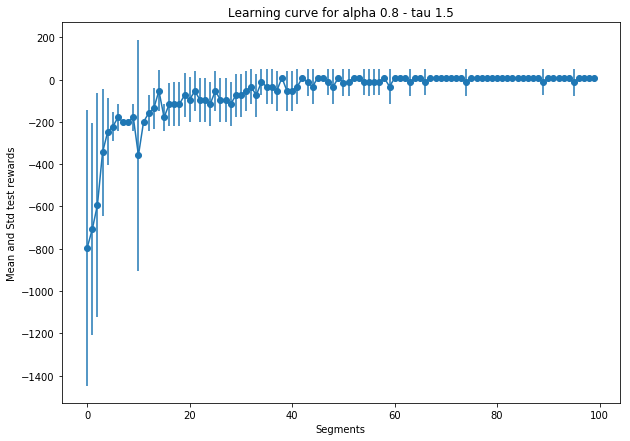

In [13]:
agents = ['q_learning']
for agent in agents:
    agent_train_rewards = np.zeros(shape=(len(temperatures), len(learning_rates)))
    agent_test_rewards = np.zeros_like(agent_train_rewards)
    for temp in temperatures:
        for learning_rate in learning_rates:
            agent_object = TaxiEnv(agent, learning_rate, temp, env, gamma=0.9)
            train_rewards, test_rewards, avg_test, std_test = agent_object.train(print_trace=True)
            agent_train_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = train_rewards
            agent_test_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = test_rewards
            
            plt.rcParams['figure.figsize'] = [10, 7]
            plot_error(np.arange(100), avg_test, std_test, learning_rate, temp)

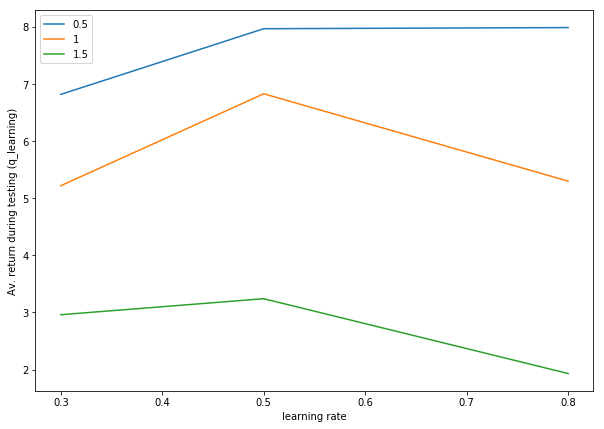

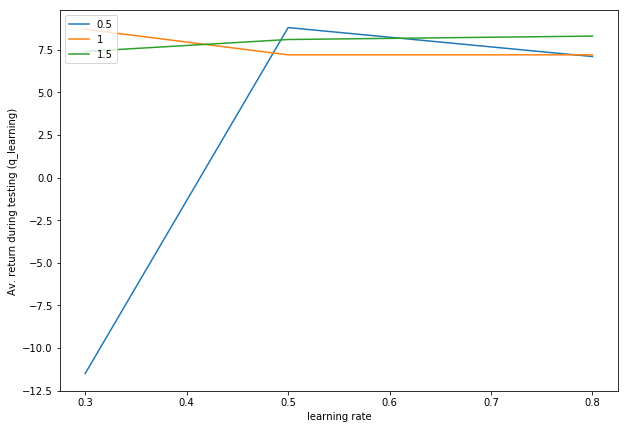

<Figure size 720x504 with 0 Axes>

In [16]:
# plots for 'q_learning' training and test
plt.rcParams['figure.figsize'] = [10, 7]
    
plot_graph(learning_rates, agent_train_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')
plot_graph(learning_rates, agent_test_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')

In [ ]:
agents = ['expected_sarsa']
for agent in agents:
    agent_train_rewards = np.zeros(shape=(len(temperatures), len(learning_rates)))
    agent_test_rewards = np.zeros_like(agent_train_rewards)
    for temp in temperatures:
        for learning_rate in learning_rates:
            agent_object = TaxiEnv(agent, learning_rate, temp, env, gamma=0.9)
            train_rewards, test_rewards, avg_test, std_test = agent_object.train(print_trace=True)
            agent_train_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = train_rewards
            agent_test_rewards[temperatures.index(temp)][learning_rates.index(learning_rate)] = test_rewards
            
            plt.rcParams['figure.figsize'] = [10, 7]
            plot_error(np.arange(100), avg_test, std_test, learning_rate, temp)

expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment  0 | train reward  -503.40, test_reward -749
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 10 | train reward  -250.30, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 20 | train reward  -259.40, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 30 | train reward  -211.00, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 40 | train reward  -191.80, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 50 | train reward  -180.90, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 60 | train reward  -216.20, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 70 | train reward  -204.40, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 80 | train reward  -191.90, test_reward -200
expected_sarsa | alpha 0.3, tau 0.50 | Run  0, Segment 90 | train reward  -184.40, test_reward -200


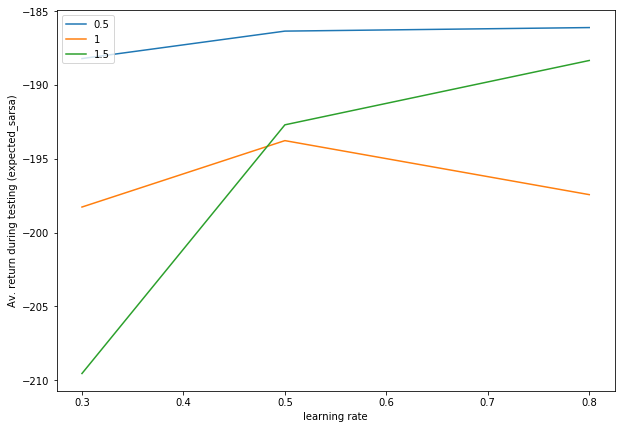

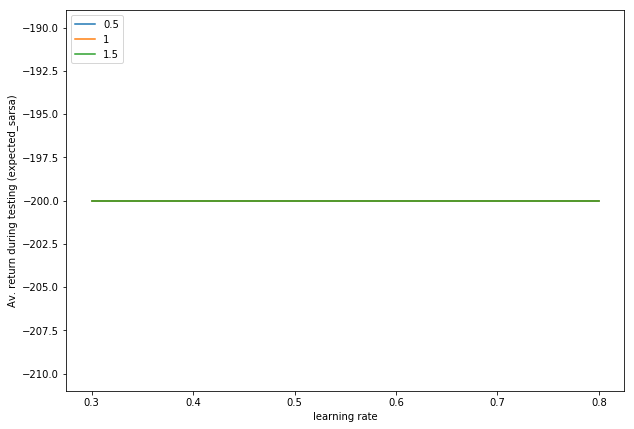

<Figure size 720x504 with 0 Axes>

In [19]:
# plots for 'q_learning' training and test
plt.rcParams['figure.figsize'] = [10, 7]
    
plot_graph(learning_rates, agent_train_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')
plot_graph(learning_rates, agent_test_rewards, temperatures, 'learning rate',
           'Av. return during testing ('+agent+')', 'av_return_l_rate_testing_'+agent+'.png')